In [251]:
import requests
import pandas as pd
import datetime

# Define the base URL and parameters
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",  # GeoJSON for easier parsing
    "starttime": "2014-01-01",
    "endtime": datetime.date.today().strftime('%y-%m-%d'), #"2023-12-31",
    "minmagnitude": 5.0,
}

# Make the request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Extract features and relevant properties
    earthquakes = data["features"]
    df = pd.json_normalize(earthquakes, sep="_")
    
    # Select relevant columns
    df = df[["properties_mag", "properties_place", "properties_time", "geometry_coordinates"]]
    df.columns = ["Magnitude", "Location", "Timestamp", "Coordinates"]
    
    # Display the DataFrame
    print(df.head(10))
    
else:
    print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")


   Magnitude                                       Location      Timestamp                    Coordinates
0        5.1                                      Banda Sea  1731332132319   [125.8652, -5.4099, 531.304]
1        5.6  Maug Islands region, Northern Mariana Islands  1731320218633    [145.7557, 20.2122, 41.918]
2        5.0                     109 km E of ‘Ohonua, Tonga  1731309297929      [-173.9119, -21.2294, 10]
3        5.0                     118 km NE of Hihifo, Tonga  1731297775746      [-173.1794, -15.0663, 10]
4        5.0                   107 km NW of Tual, Indonesia  1731278112752        [132.0684, -4.9359, 10]
5        6.8              40 km SSW of Bartolomé Masó, Cuba  1731257390382        [-77.0391, 19.8116, 14]
6        5.9                35 km S of Bartolomé Masó, Cuba  1731253802566    [-76.8901, 19.8523, 14.219]
7        5.2                  Kermadec Islands, New Zealand  1731253619031  [-177.8097, -30.4474, 36.161]
8        5.0            175 km WSW of Bayanhon

### Cleaning & transforming the data:

In [252]:
# Converting timestamp data to a regular datetime format:
df['Date_time'] = pd.to_datetime(df['Timestamp'] / 1000, unit='s')

# Getting the date from the timestamp:
df['Date'] = df['Date_time'].dt.date
df.head()

,Magnitude,Location,Timestamp,Coordinates,Date_time,Date
0,5.1,Banda Sea,1731332132319,"[125.8652, -5.4099, 531.304]",2024-11-11 13:35:32.319000006,2024-11-11
1,5.6,"Maug Islands region, Northern Mariana Islands",1731320218633,"[145.7557, 20.2122, 41.918]",2024-11-11 10:16:58.632999897,2024-11-11
2,5.0,"109 km E of ‘Ohonua, Tonga",1731309297929,"[-173.9119, -21.2294, 10]",2024-11-11 07:14:57.928999901,2024-11-11
3,5.0,"118 km NE of Hihifo, Tonga",1731297775746,"[-173.1794, -15.0663, 10]",2024-11-11 04:02:55.746000051,2024-11-11
4,5.0,"107 km NW of Tual, Indonesia",1731278112752,"[132.0684, -4.9359, 10]",2024-11-10 22:35:12.752000093,2024-11-10


In [253]:
# Splitting location data to get the country or region name:

place= []
for i in range(len(df['Location'])):
    result= df['Location'][i].split(',')
    if len(result)>1:
        place.append(df['Location'][i].split(',')[1])
    
    else:
        place.append(df['Location'][i].split(',')[0])

df['Region']= place

# Removing any extra space added in the field:
df['Region']= df['Region'].str.strip()

In [254]:
# Separating the coordinates data to get the longitude and latitude for all the regions:

long= []
lat= []
dep= []
for i in range(len(df)):
    val = df.loc[i, 'Coordinates']
    long.append(val[0])
    lat.append(val[1])
    dep.append(val[2])

df['Longitude']= long
df['Latitude']= lat
df['Depth']= dep

In [255]:
df.head()

,Magnitude,Location,Timestamp,Coordinates,Date_time,Date,Region,Longitude,Latitude,Depth
0,5.1,Banda Sea,1731332132319,"[125.8652, -5.4099, 531.304]",2024-11-11 13:35:32.319000006,2024-11-11,Banda Sea,125.8652,-5.4099,531.304
1,5.6,"Maug Islands region, Northern Mariana Islands",1731320218633,"[145.7557, 20.2122, 41.918]",2024-11-11 10:16:58.632999897,2024-11-11,Northern Mariana Islands,145.7557,20.2122,41.918
2,5.0,"109 km E of ‘Ohonua, Tonga",1731309297929,"[-173.9119, -21.2294, 10]",2024-11-11 07:14:57.928999901,2024-11-11,Tonga,-173.9119,-21.2294,10.000
3,5.0,"118 km NE of Hihifo, Tonga",1731297775746,"[-173.1794, -15.0663, 10]",2024-11-11 04:02:55.746000051,2024-11-11,Tonga,-173.1794,-15.0663,10.000
4,5.0,"107 km NW of Tual, Indonesia",1731278112752,"[132.0684, -4.9359, 10]",2024-11-10 22:35:12.752000093,2024-11-10,Indonesia,132.0684,-4.9359,10.000


### Visualizing the data:

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets

%matplotlib inline

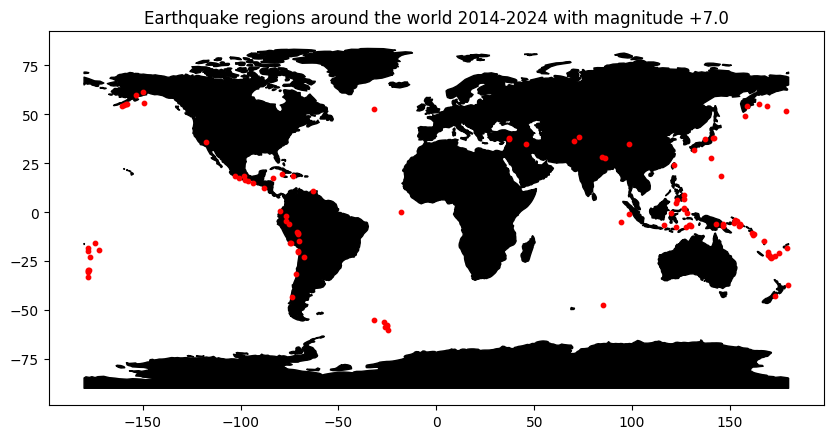

In [257]:
# Visualizing earthquake events recorded around the world:

from datetime import datetime
start_date= '2014-01-01'
start_date = pd.to_datetime(start_date).date() # The start date, starting point of the data, converting it to a date format from string

magnitude_var = 7.0 
data = df[df['Magnitude']> magnitude_var]   # Filtering data to see only events with magnitude > 7.0

# Creating a geodataframe using the longitudes & latitudes in our data
points = gpd.points_from_xy(data["Longitude"], data["Latitude"], crs="EPSG:4326")
map = gpd.GeoDataFrame (data, geometry=points) 
#map.plot()

# Load the world shapefile (downloaded from: https://www.naturalearthdata.com/downloads/110m-cultural-vectors/)
world = gpd.read_file(r'ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp')

# Plot the world map
ax = world.plot(figsize=(10, 6), color='black', edgecolor='black')

# Plot the earthquake points on top of the world map
map.plot(ax=ax, marker='o', color='red', markersize=10)
plt.title(f'Earthquake regions around the world {start_date.year}-{datetime.today().year} with magnitude +{magnitude_var}')
plt.show()

### Creating function to plot earthquake events filtered by a specified magnitude, region, date:

In [258]:
from datetime import datetime

# Defining the function with parameters: 
# --data, 
# --magnitude (optional, default value= 5.0) 
# --region (optional)
# --start_date (optional, default value= '2020-01-01')

def plot_earthquake_data(data, magnitude= 5.0, region=None, start_date= '2020-01-01'):
    
    # Load the world shapefile (natural earth or geopandas default)
    world = gpd.read_file(r'ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp')
    start_date = pd.to_datetime(start_date).date()

    if region == None:
        # Creating new dataframe for plotting based on arguments received
        new_data = df[(df['Date'] > start_date) & (df['Magnitude']>magnitude)]

        # Creating a geodataframe
        points = gpd.points_from_xy(new_data["Longitude"], new_data["Latitude"], crs="EPSG:4326")
        map = gpd.GeoDataFrame (new_data, geometry=points)

        # Plot the world map
        ax = world.plot(figsize=(10, 6), color='black', edgecolor='black')
        
    else:
        # Creating new dataframe for plotting based on arguments received
        new_data = df[(df['Region']== region) & (df['Date'] > start_date) & (df['Magnitude']>magnitude)]

        # Creating a geodataframe
        points = gpd.points_from_xy(new_data["Longitude"], new_data["Latitude"], crs="EPSG:4326")
        map = gpd.GeoDataFrame (new_data, geometry=points) 

        # Plot the regional map
        region_map = world[world.NAME_CIAWF == region]
        ax = region_map.plot(figsize=(10, 6), color='black', edgecolor='black')

    # Plot the earthquake points on top of the world map
    map.plot(ax=ax, marker='o', color='red', markersize=10)

    plt.title(f'Earthquakes in ({start_date.year}-{datetime.today().year}) with magnitude +{magnitude}')
    plt.show()


In [259]:
# List of regions that recorded earthquake events:
earthquake_regions= df['Region'].unique()
print(earthquake_regions)

['Banda Sea' 'Northern Mariana Islands' 'Tonga' 'Indonesia' 'Cuba'
 'New Zealand' 'Mongolia' 'Panama' 'southern Mid-Atlantic Ridge'
 'Japan region' 'Chile' 'Ecuador' 'West Chile Rise' 'Papua New Guinea'
 'South Sandwich Islands region' 'Peru' 'Mid-Indian Ridge' 'Taiwan'
 'Fiji region' 'Russia' 'Colombia' 'Greece' 'Alaska' 'Argentina'
 'Nicaragua' 'Fiji' 'Reykjanes Ridge' 'Mauritius - Reunion region'
 'western Indian-Antarctic Ridge' 'Oregon' 'Vanuatu'
 'south of the Fiji Islands' 'northern Mid-Atlantic Ridge' 'China'
 'French Southern Territories' 'Mexico' 'Kermadec Islands region'
 'Solomon Islands' 'Japan' 'Afghanistan' 'Turkey' 'Mariana Islands region'
 'southeast of Easter Island' 'west of Macquarie Island' 'Costa Rica'
 'south of the Kermadec Islands' 'Myanmar' 'central Mid-Atlantic Ridge'
 'southeast Indian Ridge' 'Southwest Indian Ridge' 'Venezuela'
 'central East Pacific Rise' 'Iceland' 'Ethiopia' 'Vanuatu region'
 'southern East Pacific Rise' 'Svalbard and Jan Mayen' 'Guam'
 '

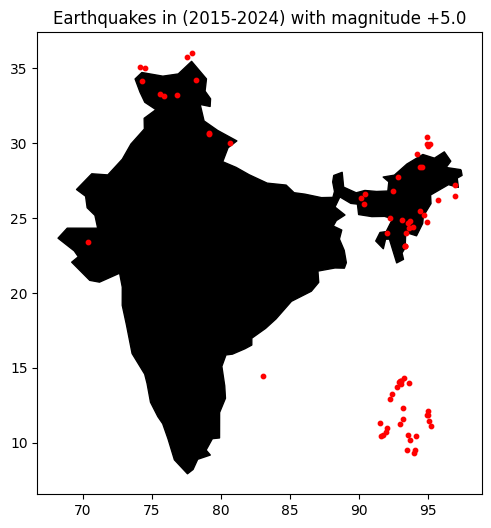

In [262]:
# Calling the 'plot_earthquake_data' function to plot earthquake events in India:
plot_earthquake_data(df, 5.0, 'India', '2015-01-01')